# Read Data From CSV

In [9]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
from numpy.linalg import norm
from quaternion import Quaternion
from scipy import stats

In [61]:
#функции калибровки
def find_offsets(mpu,counts = 15):
    calibration_set = mpu.loc[:counts]
    calibration_set =mpu 
    n = float(len(calibration_set))
    summ = []
    offsets = []
    for i in calibration_set:
        summ.append(calibration_set[i].sum())
    for s in summ:
        offsets.append(s/n)
    return offsets

def find_headers(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

def calibration(mpu,dataset):
    
    headers = find_headers(mpu)
#     print(headers)
    
    off = find_offsets(mpu)
    calibrated = dataset.copy()
    #не калибровать ускорение для фильтра маджвика!
    calibrated[headers[0]] = mpu[headers[0]] - off[0]
#     calibrated[headers[1]] = mpu[headers[1]] - off[1]
    calibrated[headers[2]] = mpu[headers[2]] - off[2]
    
    calibrated[headers[3]] = mpu[headers[3]] - off[3]
    calibrated[headers[4]] = mpu[headers[4]] - off[4]
    calibrated[headers[5]] = mpu[headers[5]] - off[5]
    
    return calibrated


In [11]:
#функции для вывода графиков
def show_plots(mpu_t,mpu_b,title_t,title_b,accel=None):
    
    headers_t = find_headers(mpu_t)
    headers_b = find_headers(mpu_b)
    
    if accel == True:
        headers_t = headers_t[:3]
        headers_b = headers_b[:3]
        title_t += ' accel'
        title_b += ' accel'
    elif accel == None:
        headers_t = headers_t[:3]
        title_t +='accel'
        headers_b = headers_b[3:]
        title_b += ' gyro'
    else:
        headers_t = headers_t[3:]
        headers_b = headers_b[3:]
        title_t += ' gyro'
        title_b += ' gyro'
        


    fig = make_subplots(rows=1, cols=2, subplot_titles=(title_t,title_b))


    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]),1,1)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]),1,1)

    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[0]],name=headers_b[0]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[1]],name=headers_b[1]),1,2)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_b[headers_b[2]],name=headers_b[2]),1,2)


    fig.update_layout(legend_orientation="h",
                      legend=dict(x=.5, xanchor="center"),
                      hovermode="x",
                      margin=dict(l=0, r=0, t=40, b=0))
    fig.show()


def show_plot(mpu_t,title_t,accel=None):
    
    headers_t = find_headers(mpu_t)
    
    if accel == True:
        headers_t = headers_t[:3]
        title_t += ' accel'
    elif accel == None:
        headers_t = headers_t
    else:
        headers_t = headers_t[3:]
        title_t += ' gyro'
        


    fig = go.Figure() 
    fig.update_layout(title=title_t)
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[0]],name=headers_t[0]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[1]],name=headers_t[1]))
    fig.add_trace(go.Scatter(x=mpu_t.index, y=mpu_t[headers_t[2]],name=headers_t[2]))

    fig.show()


In [12]:
def read_csv_file(file_path):
    df = pd.read_csv(file_path,sep = ' ',header = None)
    df.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
                 "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
                 "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
                 "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
                "s5","rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz",
                 "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
                 ]

    return df

In [13]:
#each  IMU for calibration
def parse_to_sensors(df):
    bt = df[["bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz"]]
    bb = df[["bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz"]]
    lt = df[["lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz"]]
    lb = df[["lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz"]]
    rt = df[["rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz"]]
    rb = df[["rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz"]]
    
#     show_plot(lb,'Non calibrated left-bot ',True)
#     show_plot(lb,'Non calibrated left-bot ',False)
    return bt,bb,lt,lb,rt,rb


# Filter outliers

In [76]:
def filter_outliers(df_local):
    
    outl = find_headers(df_local)
    df= df_local.copy()
    for o in outl:
        median = df[o].median()
        std = df[o].std()
        df.loc[(df[o] - median).abs() > std,o]=np.nan
        df[o].fillna(median, inplace=True)
    return df

def find_outliers(df):
    
    bt,bb,lt,lb,rt,rb = parse_to_sensors(df)
    
    rb_outl = filter_outliers(rb)
    rt_outl =filter_outliers(rt)
    lb_outl = filter_outliers(lb)
    lt_outl = filter_outliers(lt)
    bb_outl = filter_outliers(bb)
    bt_outl = filter_outliers(bt)
    

#     show_plot(lb,'With outliers ',False)
#     show_plot(lb_outl,'With outliers ',False)
#     show_plot(calibrated_lb,'Without outliers',False)

    return bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl 

# def all_calibrate(df):
#     calibration()

# calibration_frame = find_outliers(df)
# calibration_frame
# show_plot(lb,'With outliers ',True)
# show_plot(lb_outl,'Without outliers',True)

In [77]:
# df

 Calibrate DF of each sensor

# Madgwick filter

In [113]:
def find_orientation(calibrated_mpu):
    
    headers = find_headers(calibrated_mpu)
        
    quaternions = []

    heading = mg.MadgwickAHRS(sampleperiod = 0.06,beta = 1)
    for i,row in calibrated_mpu.iterrows():
        gyro_d  = []
        accel_d = []
        gyro_d.append(row[headers[3]])
        gyro_d.append(row[headers[4]])
        gyro_d.append(row[headers[5]])
        accel_d.append(row[headers[0]])
        accel_d.append(row[headers[1]])
        accel_d.append(row[headers[2]])

        heading.update_imu(gyro_d,accel_d)
        quaternions.append(heading.quaternion._get_q())

    # print(quaternions)
    pitch = []
    roll = []
    yaw = []
    for i in range(len(quaternions)):
        pitch.append(np.arcsin(2 * quaternions[i][1] * quaternions[i][2] + 2 * quaternions[i][0] * quaternions[i][3]))
        if np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] - 0.5) < 1e-8:
            roll.append(0) 
            yaw.append(2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
        elif np.abs(quaternions[i][1] * quaternions[i][2] + quaternions[i][3] * quaternions[i][0] + 0.5) < 1e-8:
            roll.append(-2 * np.arctan2(quaternions[i][1], quaternions[i][0]))
            yaw.append(0)
        else:
            roll.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][1] - 2 * quaternions[i][2] *quaternions[i][3], 1 - 2 * quaternions[i][1] ** 2 - 2 *quaternions[i][3] ** 2))
            yaw.append(np.arctan2(2 * quaternions[i][0] * quaternions[i][2] - 2 * quaternions[i][1] * quaternions[i][3], 1 - 2 * quaternions[i][2] ** 2 - 2 * quaternions[i][3] ** 2))


    orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})
    return orientation_d

    

# Calibration data

In [159]:
# df_1 = pd.read_csv('dataset/7_Danya5.csv',sep = ' ',header = None)
# df_1.columns = ["s1","bt_ax","bt_ay","bt_az","bt_gx","bt_gy","bt_gz",
#              "s2","bb_ax","bb_ay","bb_az","bb_gx","bb_gy","bb_gz",
#              "s3","lt_ax","lt_ay","lt_az","lt_gx","lt_gy","lt_gz",
#              "s4","lb_ax","lb_ay","lb_az","lb_gx","lb_gy","lb_gz",
#             "s5","rt_ax","rt_ay","rt_az","rt_gx","rt_gy","rt_gz",
#              "s6","rb_ax","rb_ay","rb_az","rb_gx","rb_gy","rb_gz",
#              ]
# df



import os
from os import walk
def all_calibrate(calibration_set,dataset):
    
    bt_1,bb_1,lt_1,lb_1,rt_1,rb_1=parse_to_sensors(dataset) 

#     rb_outl,rt_outl,lb_outl,lt_outl,bb_outl,bt_outl =  find_outliers(calibration_set)
    bt_outl,bb_outl,lt_outl,lb_outl,rt_outl,rb_outl =  find_outliers(calibration_set)
    
    show_plot(bt_outl,'first ',False)
    
    calibrated_rb = calibration(rb_outl,rb_1)
    calibrated_rt = calibration(rt_outl,rt_1)
    calibrated_lb = calibration(lb_outl,lb_1)
    calibrated_lt = calibration(lt_outl,lt_1)
    calibrated_bb = calibration(bb_outl,bb_1)
    calibrated_bt = calibration(bt_outl,bt_1)
    
    ready_dataset = pd.concat([calibrated_bt, calibrated_bb, calibrated_lt, calibrated_lb, calibrated_rt, calibrated_rb],axis = 1,)    

#     show_plot(calibrated_bt,'without outliers ',True)

#     print(calibrated_rb)
    
    orientation_lb = find_orientation(calibrated_lb)
    orientation_lt = find_orientation(calibrated_lt)
    orientation_bb = find_orientation(calibrated_bb)
    orientation_bt = find_orientation(calibrated_bt)
    orientation_rb = find_orientation(calibrated_rb)
    orientation_rt = find_orientation(calibrated_rt)
    

#     orientation_lb_1 = filter_scipy(orientation_lb)
#     orientation_lt_1 = filter_scipy(orientation_lb)
#     orientation_bb_1 = filter_scipy(orientation_lb)
#     orientation_bt_1 = filter_scipy(orientation_lb)
#     orientation_rb_1 = filter_scipy(orientation_lb)
#     orientation_rt_1 = filter_scipy(orientation_lb)
  
    
#     return   orientation_rb_1, orientation_rt_1, orientation_bb_1, orientation_bt_1, orientation_lb_1, orientation_lt_1
    return   orientation_rb, orientation_rt, orientation_bb, orientation_bt, orientation_lb, orientation_lt
    


сalibration_set= read_csv_file('calibration/10_Vadim.csv')


filenames = next(walk('D:/Thesis/Vadim/'), (None, None, []))[2]  # [] if no file
filenames[0]
for i in range(len(filenames)):
    filename = f"D:/Thesis/Vadim/{filenames[i]}"
    print(filename)
    IMU_set = read_csv_file(filename)
    orientation_rb, orientation_rt, orientation_bb, orientation_bt, orientation_lb, orientation_lt = all_calibrate(сalibration_set,IMU_set)
    ready_dataset = pd.concat([orientation_bt, orientation_bb, orientation_lt, orientation_lb, orientation_rt, orientation_rb],axis = 1)    
#     print(ready_dataset)
    ready_dataset.to_csv(f"D:\Thesis\dataset\lifting_orientation_{i}_0.csv", sep=",")

    
# orientation_lb = find_orientation(calibrated_lb)
# show_plot(orientation_rt,'Orientation left_bot sensor')

# def all_find_orientations(calibrated_lb,):
    
# def all_calibrated(df):
  
# #первый фрейм калибровочный файл
# calibrated_lb = calibration(lt_outl,lt_1)
# #calibrated_lb = lb_1



D:/Thesis/Vadim/10_Vadim.csv


D:/Thesis/Vadim/__Vadim1.csv


D:/Thesis/Vadim/__Vadim10.csv


D:/Thesis/Vadim/__Vadim11.csv


D:/Thesis/Vadim/__Vadim12.csv


D:/Thesis/Vadim/__Vadim13.csv


D:/Thesis/Vadim/__Vadim14.csv


D:/Thesis/Vadim/__Vadim15.csv


D:/Thesis/Vadim/__Vadim16.csv


D:/Thesis/Vadim/__Vadim17.csv


D:/Thesis/Vadim/__Vadim18.csv


D:/Thesis/Vadim/__Vadim19.csv


D:/Thesis/Vadim/__Vadim2.csv


D:/Thesis/Vadim/__Vadim20.csv


D:/Thesis/Vadim/__Vadim21.csv


D:/Thesis/Vadim/__Vadim22.csv


D:/Thesis/Vadim/__Vadim23.csv


D:/Thesis/Vadim/__Vadim24.csv


D:/Thesis/Vadim/__Vadim25.csv


D:/Thesis/Vadim/__Vadim26.csv


D:/Thesis/Vadim/__Vadim27.csv


D:/Thesis/Vadim/__Vadim28.csv


D:/Thesis/Vadim/__Vadim29.csv


D:/Thesis/Vadim/__Vadim3.csv


D:/Thesis/Vadim/__Vadim30.csv


D:/Thesis/Vadim/__Vadim31.csv


D:/Thesis/Vadim/__Vadim4.csv


D:/Thesis/Vadim/__Vadim5.csv


D:/Thesis/Vadim/__Vadim6.csv


D:/Thesis/Vadim/__Vadim7.csv


D:/Thesis/Vadim/__Vadim8.csv


D:/Thesis/Vadim/__Vadim9.csv


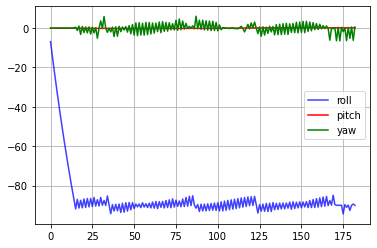

In [158]:
test_plot = pd.read_csv('D:/Thesis/dataset/lifting_orientation_0_0.csv')

def preprocessing_dataset(dataset):
    df = dataset.drop(columns = "Unnamed: 0")
    df.columns = ["roll_bt","pitch_bt","yaw_bt",
                  "roll_bb","pitch_bb","yaw_bb",
                  "roll_lt","pitch_lt","yaw_lt",
                  "roll_lb","pitch_lb","yaw_lb",
                  "roll_rt","pitch_rt","yaw_rt",
                  "roll_rb","pitch_rb","yaw_rb"
                 ]
    return df
test_plot_1 = preprocessing_dataset(test_plot)

orientation_lb_test= test_plot_1[["roll_lb","pitch_lb","yaw_lb"]]
show_plot(orientation_lb_test,'Orientation left_bot sensor')


plt.figure
plt.plot(orientation_lb_test.index, orientation_lb_test["roll_lb"], 'b', alpha=0.75)
plt.plot(orientation_lb_test.index, frame['pitch'], 'r', orientation_lb_test.index,  orientation_lb_test["yaw_lb"], 'g')
plt.legend(('roll', 'pitch', 'yaw'), loc='best')
plt.grid(True)
plt.show()


In [90]:
orientation_lb_test.loc[:]

,roll_lb,pitch_lb,yaw_lb
0,-6.882342,-0.000063,-0.029037
1,-13.659862,0.022944,-0.020494
2,-20.289855,0.024257,-0.025490
3,-26.731326,-0.006344,-0.048778
4,-33.021446,-0.009012,-0.014796
...,...,...,...
178,-89.956746,0.143484,0.322702
179,-92.648267,0.257804,-5.191611
180,-90.035659,0.151753,0.617519
181,-89.389498,0.119878,-6.230472


# find orientation

In [17]:
import madgwickahrs as mg
from quaternion import Quaternion

In [18]:
#find only with gyro 

pitch = np.zeros(len(calibrated_lb))
yaw = np.zeros(len(calibrated_lb))
roll = np.zeros(len(calibrated_lb))

for i in range(len(calibrated_lb)-1):
    delta_t = 0.06
    
    pitch[i+1] = pitch[i] + calibrated_lb['lb_gy'][i]*delta_t
    yaw[i+1] = yaw[i]+calibrated_lb['lb_gz'][i]*delta_t
    roll[i+1] = roll[i]+calibrated_lb['lb_gx'][i]*delta_t
    

orientation_d = pd.DataFrame({'roll':np.rad2deg(roll),'pitch':np.rad2deg(pitch),'yaw':np.rad2deg(yaw)})

show_plot(orientation_d,'Orientation only with  gyro')


NameError: name 'calibrated_lb' is not defined

# Filter dataset

In [104]:
from scipy import signal
import matplotlib.pyplot as plt

In [132]:
def find_headers_orient(mpu):
    headers = []
    for i in mpu:
        headers.append(i)
    return headers

In [128]:
def filter_scipy(dataset):
    xn = dataset
    b, a = signal.butter(3, 0.05)
    zi = signal.lfilter_zi(b, a)
    z, _ = signal.lfilter(b, a, xn, zi=zi* xn[0])
    z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    y = signal.filtfilt(b, a, xn)
    plt.figure
    plt.plot(orientation_lb_test.index, xn, 'b', alpha=0.75)
    plt.plot(orientation_lb_test.index, z, 'r--', orientation_lb_test.index, z2, 'r', orientation_lb_test.index, y, 'k')
    plt.legend(('noisy signal', 'lfilter, once', 'lfilter, twice',
            'filtfilt'), loc='best')
    plt.grid(True)
    plt.show()
    print(y)
    
    return y

In [115]:
# xn = orientation_lb_test['yaw_lb']
# b, a = signal.butter(3, 0.05)
# zi = signal.lfilter_zi(b, a)
# z, _ = signal.lfilter(b, a, orientation_lb_test['yaw_lb'], zi=zi* orientation_lb_test['yaw_lb'][0])

In [133]:
# z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
# y = signal.filtfilt(b, a, xn)
headers_orient  = find_headers_orient(orientation_lb_test)
headers_orient

['roll_lb', 'pitch_lb', 'yaw_lb']

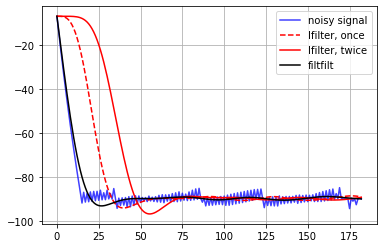

[ -6.8732866  -12.88507481 -18.89154914 -24.85035196 -30.71994713
 -36.46023706 -42.03315203 -47.40320513 -52.53800701 -57.40873447
 -61.99054687 -66.26294245 -70.21004569 -73.8208139  -77.08914935
 -80.01389954 -82.59872784 -84.85184397 -86.78560325 -88.41600092
 -89.76209432 -90.84538296 -91.6891732  -92.31795079 -92.75677988
 -93.03074357 -93.16443704 -93.18152213 -93.10434938 -92.95365049
 -92.74830053 -92.50514806 -92.23891271 -91.96214903 -91.68527184
 -91.41663896 -91.16268885 -90.92812387 -90.71611759 -90.52852391
 -90.36607757 -90.22858458 -90.11510209 -90.02410529 -89.95363816
 -89.90144593 -89.86508836 -89.84203487 -89.82974311 -89.82572309
 -89.82758919 -89.8331022  -89.84020297 -89.84703871 -89.85198287
 -89.85364931 -89.85090174 -89.84285942 -89.82890048 -89.80866285
 -89.78204163 -89.74918198 -89.7104677  -89.66650611 -89.61810998
 -89.56627685 -89.51216498 -89.45706599 -89.40237447 -89.34955526
 -89.30010861 -89.25553313 -89.2172873  -89.18675067 -89.16518546
 -89.15369

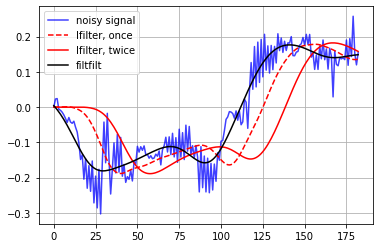

[ 0.00419264 -0.00123864 -0.00712617 -0.01347183 -0.02027047 -0.02750904
 -0.0351658  -0.04320977 -0.05160042 -0.06028748 -0.06921095 -0.07830142
 -0.08748069 -0.09666285 -0.10575588 -0.11466385 -0.12328965 -0.13153815
 -0.13931944 -0.14655199 -0.15316549 -0.15910321 -0.16432378 -0.16880245
 -0.1725317  -0.17552131 -0.17779781 -0.17940314 -0.18039249 -0.18083126
 -0.18079122 -0.18034617 -0.17956791 -0.17852299 -0.17727074 -0.17586227
 -0.17434018 -0.1727382  -0.17108107 -0.16938472 -0.16765685 -0.16589825
 -0.16410449 -0.16226798 -0.16038017 -0.15843345 -0.15642263 -0.15434577
 -0.15220454 -0.15000396 -0.14775168 -0.14545714 -0.14313058 -0.14078238
 -0.1384227  -0.13606149 -0.13370884 -0.13137555 -0.12907387 -0.12681816
 -0.12462549 -0.12251602 -0.12051313 -0.11864333 -0.11693591 -0.1154224
 -0.11413561 -0.11310858 -0.11237319 -0.11195892 -0.11189167 -0.11219268
 -0.11287758 -0.11395545 -0.11542802 -0.1172888  -0.11952233 -0.12210336
 -0.12499626 -0.12815452 -0.13152063 -0.1350262  -0.

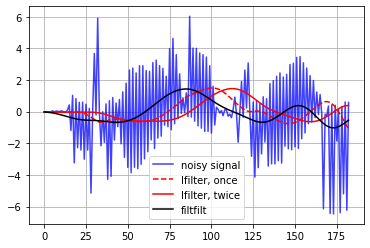

[-0.01580063 -0.02390481 -0.03412224 -0.0465891  -0.06140239 -0.07861229
 -0.09821482 -0.12014546 -0.14427407 -0.17040172 -0.19825953 -0.2275101
 -0.25775188 -0.28852679 -0.31933147 -0.34963258 -0.37888696 -0.40656711
 -0.43219082 -0.45535178 -0.47574683 -0.49319617 -0.50765626 -0.51922651
 -0.52814994 -0.53480713 -0.53970184 -0.54343745 -0.54668375 -0.55013121
 -0.55442845 -0.56010593 -0.5675036  -0.57672464 -0.58762926 -0.59986667
 -0.61292948 -0.62621266 -0.6390681  -0.65085209 -0.66096189 -0.66885756
 -0.67406823 -0.6761861  -0.67485446 -0.66975564 -0.66060293 -0.64713808
 -0.62913323 -0.60639567 -0.57877328 -0.54615955 -0.50849774 -0.4657841
 -0.4180706  -0.3654672  -0.3081435  -0.24632914 -0.18031247 -0.11043724
 -0.03709836  0.03926309  0.11816538  0.19909277  0.28150347  0.36483849
  0.44852995  0.53200759  0.61470345  0.69605543  0.77550996  0.85252407
  0.9265678   0.99712801  1.06371384  1.1258645   1.18315899  1.2352254
  1.28174642  1.32245846  1.35714393  1.38561798  1.40

In [143]:
filtered_roll =  filter_scipy(orientation_lb_test[headers_orient[0]])
filtered_pitch =  filter_scipy(orientation_lb_test[headers_orient[1]]) 
filtered_yaw =  filter_scipy(orientation_lb_test[headers_orient[2]])


filtered_roll_pd = pd.DataFrame(filtered_roll)
filtered_pitch_pd = pd.DataFrame(filtered_pitch)
filtered_yaw_pd = pd.DataFrame(filtered_yaw)
frame = pd.concat([filtered_roll_pd,filtered_pitch_pd,filtered_yaw_pd],axis = 1)


In [146]:
frame.columns = ["roll", "pitch", "yaw"]

In [147]:
frame

,roll,pitch,yaw
0,-6.873287,0.004193,-0.015801
1,-12.885075,-0.001239,-0.023905
2,-18.891549,-0.007126,-0.034122
3,-24.850352,-0.013472,-0.046589
4,-30.719947,-0.020270,-0.061402
...,...,...,...
178,-89.867025,0.146436,-0.838133
179,-89.911757,0.147125,-0.768644
180,-89.949027,0.147741,-0.694220
181,-89.979169,0.148277,-0.617826


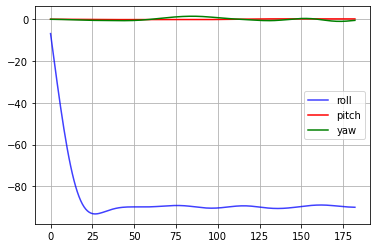

In [156]:
plt.figure
plt.plot(frame.index, frame['roll'], 'b', alpha=0.75)
plt.plot(frame.index, frame['pitch'], 'r', frame.index,  frame['yaw'], 'g')
plt.legend(('roll', 'pitch', 'yaw'), loc='best')
plt.grid(True)
plt.show()




In [ ]:
#(-0.02213089742574257, 0.01005698124752475, -0.013309934386138617)